In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.transforms as mtransforms


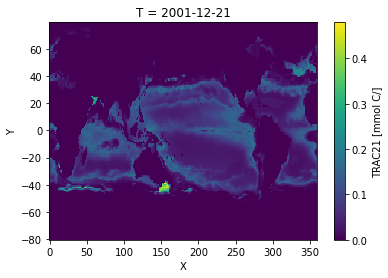

In [2]:
# gluing the tiles together
#opening files, putting each 1/16 of the earth in a list
globe_dss = []
for x_idx in range(1,5):
    for y_idx in range(1,5):
        files = f"/Users/birdy/Documents/eaps_research/darwin3/verification/dar_one_config/run/globe-yr-avg-{x_idx}-{y_idx}/run/ecco_gud_20230208_0001/3d*"
        ds = xr.open_mfdataset(files)
        ds = ds.rename({"Zmd000001":"Z"})
        globe_dss.append(ds)
        
# concatinating datasets together 
y_globe_dss = []
for i in range(0,16, 4):
    ds = xr.concat(globe_dss[i:i+4], dim="Y")
    ds = ds.assign_coords({"Y": range(0, 160)})
    y_globe_dss.append(ds)

ss_ds = xr.concat(y_globe_dss, dim="X")
ss_ds = ss_ds.assign_coords({"X": range(0, 360)})
ss_ds = ss_ds.assign_coords({"Y": range(-80, 80)})

# plot pro, to show that it worked
ss_ds.isel(T=0, Z=0)["TRAC21"].plot()

In [4]:
# load up global ds
file = "/Users/birdy/Documents/eaps_research/gcm_analysis/gcm_data/darwin_weekly_seasonal/3d.nc"
global_ds = xr.open_dataset(file)
global_ds = global_ds.rename({"Zmd000023":"Z"})

# Calculating Bray-Curtis Dissimilarity 

In [5]:
global_ds = global_ds.fillna(0)
ss_ds = ss_ds.fillna(0)

In [6]:
# BC_ij = 1 - (2*C_ij)/(S_i + S_j)
# S_i = sum of all biomass in SS
# S_j = sum of all biomass in global run 
#C_ij = for each organism, sum(min(SS[TRAC21], global[TRAC21]))
def bray_curtis(ss_ds, global_ds):
    # do NOT include diazotrophs 
    tracer_ids = list(range(21,30)) + list(range(35,71))
    s_i = 0
    s_j = 0
    c_list = []
    for i in tracer_ids:
        tracer_name = f"TRAC{i}"
        s_i =  s_i + ss_ds[tracer_name]
        s_j =  s_j + global_ds[tracer_name]
        temp = np.minimum(ss_ds[tracer_name].to_numpy(), global_ds[tracer_name].to_numpy())
        c_list.append(temp)
    c_ij = np.sum(c_list, axis=0)
    top = (2*c_ij)
    bottom = np.sum([s_i, s_j], axis=0)
    ones = np.ones((160, 360))
    bc_ij = ones - top/bottom
    return bc_ij

In [7]:
i_ds = ss_ds.isel(Z=0, T=-1)
j_ds = global_ds.isel(Z=0, T=1)
res = bray_curtis(i_ds, j_ds)

bc_da = xr.DataArray(
    data=res,
    dims=["Y", "X"],
    coords = {"Y":global_ds.Y, "X":global_ds.X})
bc_da

/var/folders/3d/888v68391rv_kgq9_5s8b2x80000gn/T/ipykernel_10075/369424387.py:21: RuntimeWarning: invalid value encountered in true_divide
  bc_ij = ones - top/bottom


<xarray.DataArray (Y: 160, X: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.9761045 , 0.97610883, 0.9758088 , ..., 0.97551665, 0.97453847,
        0.97519398],
       [0.96903918, 0.96740256, 0.9662339 , ..., 0.96709863, 0.96856499,
        0.96953184],
       [0.9523985 , 0.95677661, 0.94906705, ..., 0.94984784, 0.95592978,
        0.95768943]])
Coordinates:
  * Y        (Y) float64 -79.5 -78.5 -77.5 -76.5 -75.5 ... 76.5 77.5 78.5 79.5
  * X        (X) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

# Calculating Diversity Index

In [8]:
# di = s_t / i_t
# s_t = total number of different species
# i_t = total individuals 
def diversity_index(ds):
    # do NOT include diazotrophs 
    tracer_ids = list(range(21,30)) + list(range(35,71))
    s_t = np.zeros((160, 360))
    i_t = np.zeros((160,360))
    for i in tracer_ids:
        tracer_name = f"TRAC{i}"
        has_tracer = ds[tracer_name] > 1e-6
        s_t = s_t + has_tracer
        i_t = i_t + ds[tracer_name]
    di = i_t / s_t
    return di



In [9]:
ss_di = diversity_index(ss_ds.isel(T=-1))
global_di = diversity_index(global_ds.isel(Z=0, T=1))

# Making the Figure 

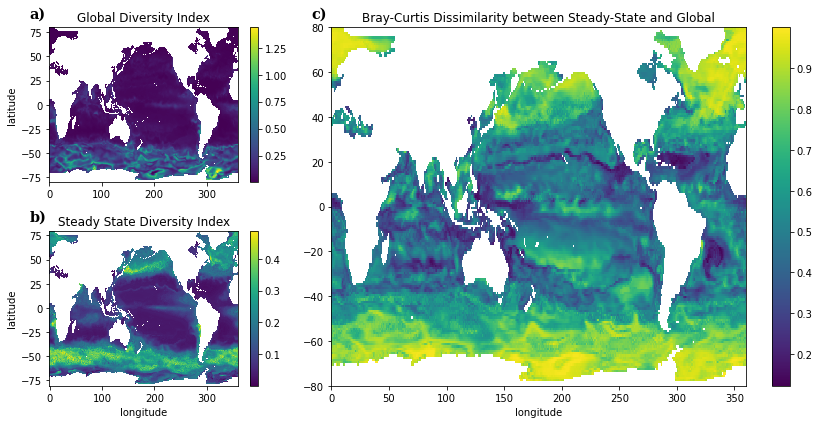

In [112]:
fig = plt.figure(figsize=(12, 6), layout="tight")
gs = fig.add_gridspec(ncols=3, nrows=2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[:,1:])

global_di.plot(ax=ax1)
ax1.set_title("Global Diversity Index")
ax1.set_xlabel(None)
ax1.set_ylabel("latitude")
# ax1.set_title("a)", fontfamily='serif', loc='left', fontsize='x-large', fontweight='bold')

ss_di.plot(ax=ax2)
ax2.set_title("Steady State Diversity Index")
ax2.set_xlabel("longitude")
ax2.set_ylabel("latitude")
# ax2.set_title("b)", fontfamily='serif', loc='left', fontsize='x-large', fontweight='bold')

bc_da.plot(ax=ax3)
ax3.set_title("Bray-Curtis Dissimilarity between Steady-State and Global")
ax3.set_xlabel("longitude")
ax3.set_ylabel(None)

# ax3.set_title("c)", fontfamily='serif', loc='left', fontsize='x-large', fontweight='bold')

for ax, label in [(ax1, "a)"), (ax2, "b)"), (ax3, "c)")]:
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='x-large', va='bottom', fontfamily='serif', fontweight='bold')
    
plt.show()

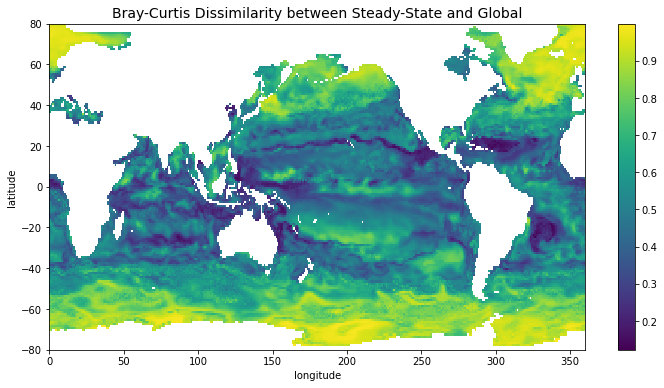

In [18]:
fig, ax = plt.subplots()
bc_da.plot(ax=ax)
ax.set_title("Bray-Curtis Dissimilarity between Steady-State and Global", fontsize=14)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
fig.set_size_inches(12,6)
plt.show()

# Plot DARWIN total biomass

In [52]:
# dset: xarray dataset or dataArray 
# variables: list of variables that exist in dset to be summed 
# new_name: what to call the new variable
# returns the dset with a new variable created with new_name and attributes
def ds_sum_variables(dset, variables, new_name, new_units="", new_description=""):
    c_total = dset[variables[0]]
    for var in variables[1:]:
        c_next = dset[var]
        c_total = c_total + c_next
    c_total = c_total.assign_attrs({'units':new_units, 'description': new_description})
    dset = dset.assign({new_name:c_total})
    return dset

biomass_vars = []
for i in range(21,70):
    biomass_vars.append(f"TRAC{i}")

In [53]:
# load up global ds
file = "/Users/birdy/Documents/eaps_research/gcm_analysis/gcm_data/darwin_weekly_seasonal/3d.nc"
global_ds = xr.open_dataset(file)
global_ds = global_ds.rename({"Zmd000023":"Z"})

In [54]:
global_ds = ds_sum_variables(global_ds, biomass_vars, "total_biomass")
global_ds

<xarray.Dataset>
Dimensions:        (Z: 23, X: 360, Y: 160, T: 52)
Coordinates:
  * X              (X) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * Y              (Y) float64 -79.5 -78.5 -77.5 -76.5 ... 76.5 77.5 78.5 79.5
  * T              (T) datetime64[ns] 2008-11-15 2008-11-22 ... 2009-11-07
Dimensions without coordinates: Z
Data variables: (12/78)
    diag_levels    (Z) float64 ...
    iter           (T) int32 ...
    TRAC01         (T, Z, Y, X) float32 ...
    TRAC02         (T, Z, Y, X) float32 ...
    TRAC03         (T, Z, Y, X) float32 ...
    TRAC04         (T, Z, Y, X) float32 ...
    ...             ...
    PP             (T, Z, Y, X) float32 ...
    Nfix           (T, Z, Y, X) float32 ...
    Denit          (T, Z, Y, X) float32 ...
    pH             (T, Z, Y, X) float32 ...
    pCO2           (T, Z, Y, X) float32 ...
    total_biomass  (T, Z, Y, X) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/18)
    MITgcm_version:  checkpoint68b
    build_user:      stephdut
    build_host:      node080
    build_date:      Thu Aug 26 12:06:38 EDT 2021
    MITgcm_URL:      http://mitgcm.org
    MITgcm_tag_id:   
    ...              ...
    nSy:             1
    nPx:             12
    nPy:             8
    Nx:              360
    Ny:              160
    Nr:              23

In [34]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [47]:
np.where(global_ds['total_biomass'] == 0)

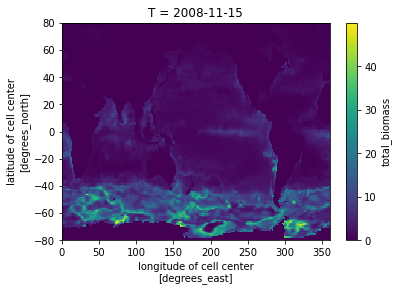

In [60]:
global_ds["total_biomass"].isel(T=0, Z=0).plot()

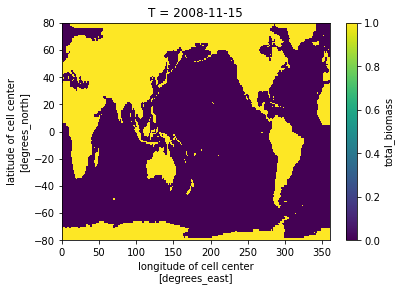

In [64]:
land = global_ds["total_biomass"].isel(T=0, Z=0) == 0
land.plot()

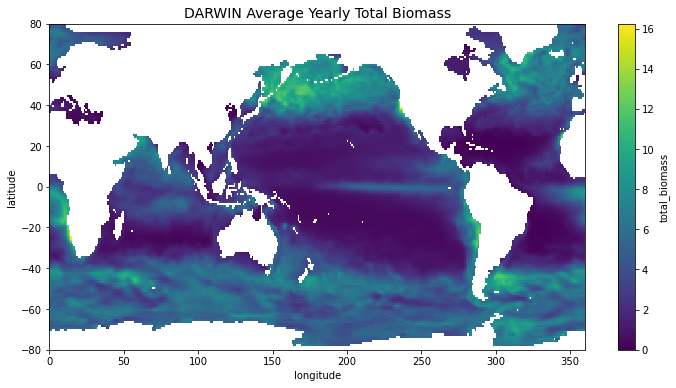

In [77]:
fig, ax = plt.subplots()
global_ds["total_biomass"].mean(dim="T").isel(Z=0).plot(ax=ax)
land.plot(ax=ax, alpha=land, cmap='gray', add_colorbar=False)
ax.set_title("DARWIN Average Yearly Total Biomass", fontsize = 14)
ax.set_ylabel("latitude")
ax.set_xlabel("longitude")
fig.set_size_inches(12, 6)
plt.show()

# Single Cell Steady State visualization by size class

In [78]:
%run /Users/birdy/Documents/eaps_research/gcm_analysis/MAIN_darwin_helper.ipynb

In [79]:
helper = DarwinHelper()

In [80]:
ss_ds = helper.sum_size_classes(ss_ds)

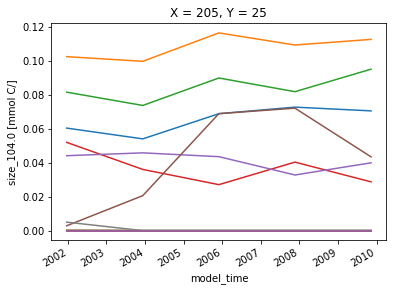

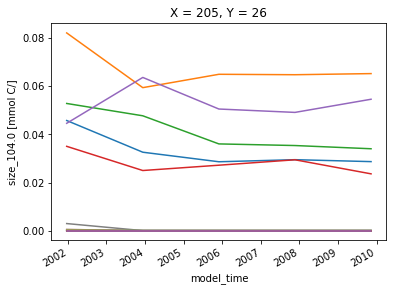

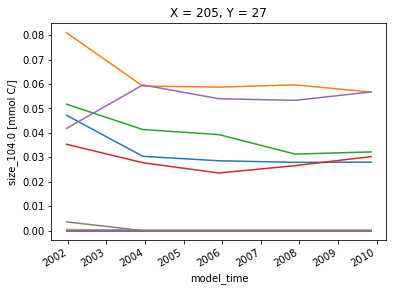

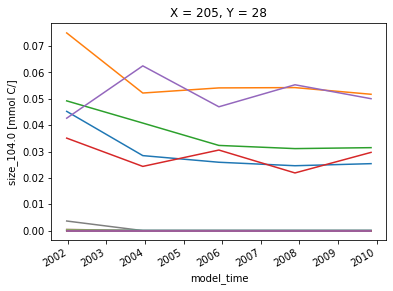

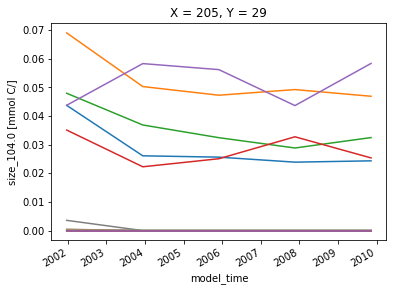

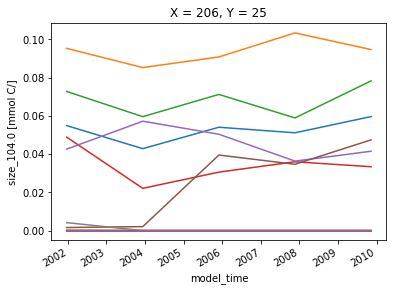

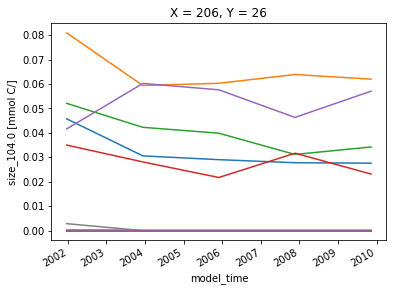

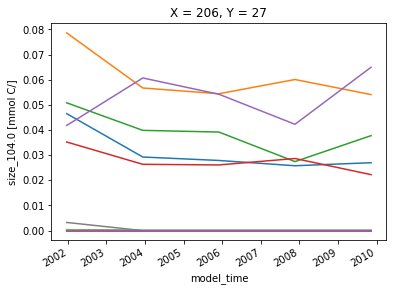

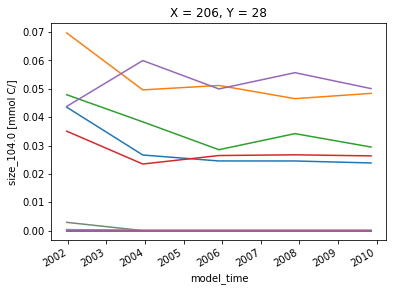

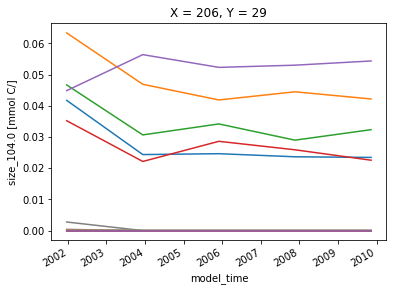

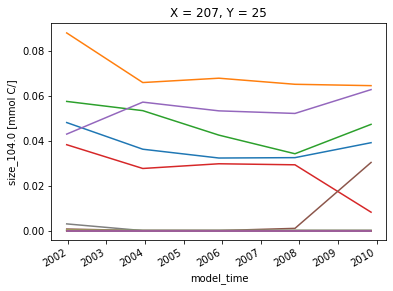

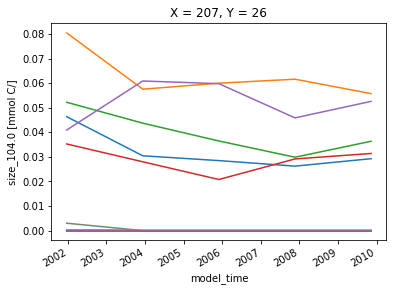

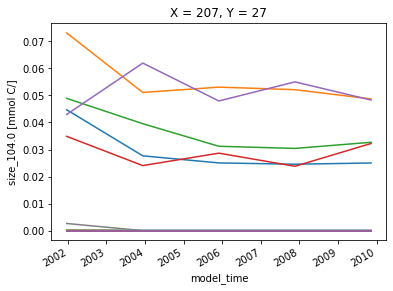

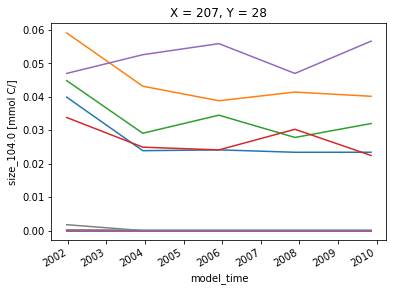

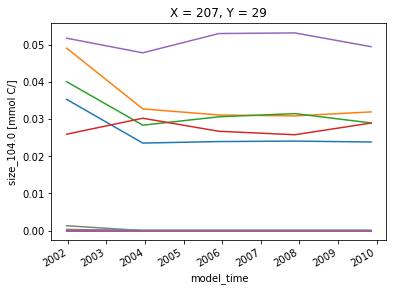

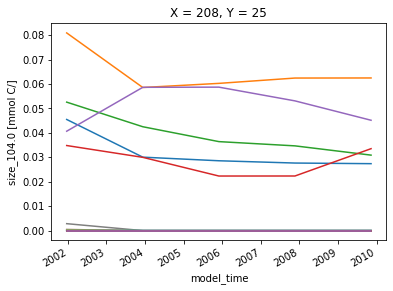

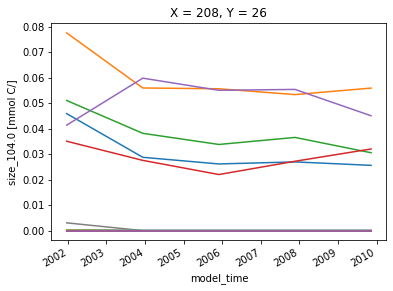

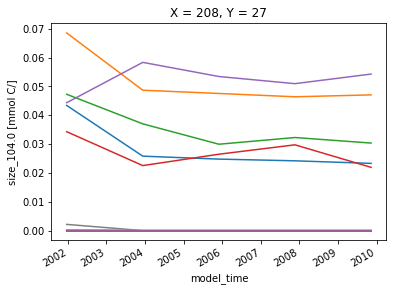

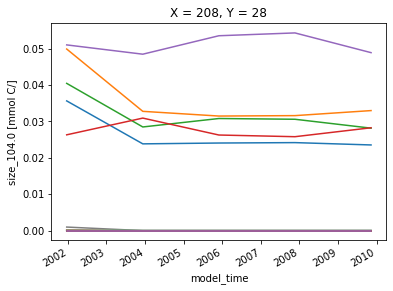

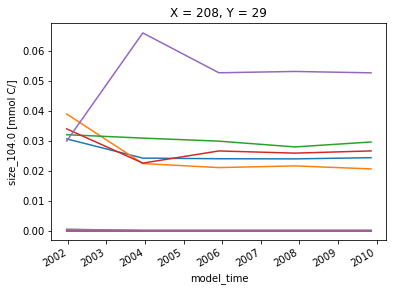

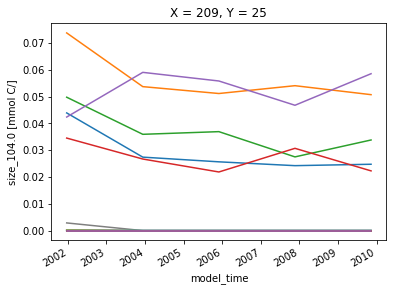

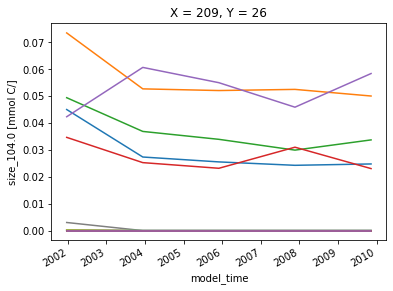

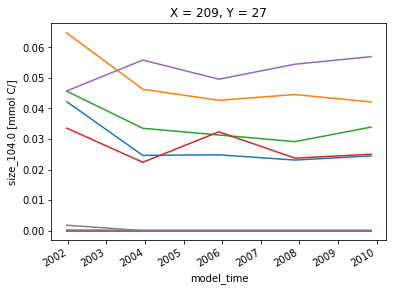

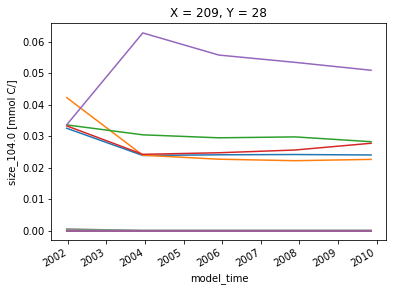

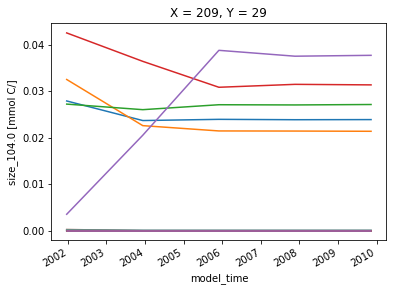

In [87]:

for lon in range(205, 210):
    for lat in range(25,30):
        for tracer in helper.size_tracers:
            ss_ds[tracer].sel(X=lon, Y=lat).plot()
        plt.show()

In [3]:
ss_ds.T

<xarray.DataArray 'T' (T: 5)>
array(['2001-12-21T00:00:00.000000000', '2003-12-11T00:00:00.000000000',
       '2005-11-30T00:00:00.000000000', '2007-11-20T00:00:00.000000000',
       '2009-11-09T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * T        (T) datetime64[ns] 2001-12-21 2003-12-11 ... 2007-11-20 2009-11-09
Attributes:
    long_name:  model_time